# Explores osm_build_network

This notebook is for snapping of substations to lines

### Jupyter notebook needs to be improved (content and structure?). 

It seems also geoplot need to be added to the environment. How to: 
- One need to deinstall the whole environment locally and install everything from scratch from the environment.yaml. Thereby the environment.yaml needs now `geoplot`.
- Subsequently, one need to test if there are any conflicts using geoplot in the other scripts (geoplot might be in conflict with other packages)

In [2]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import pandas as pd
import numpy as np
import pandas as pd
import hvplot.pandas

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

import sys

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 0 folder(s) up.


# Country/Continent shape data

In [3]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#africa = world.query('continent == "Africa"')
nigeriaplot = world.query('name == "Nigeria"') # Country chosen for notebooks
# world

# Power data

In [4]:
# choose the option to get your plot
# option = 'raw'
# option = 'clean'
option = "line2network"
raw_path = "pypsa-earth/resources/osm/raw"
clean_path = "pypsa-earth/resources/osm/clean"
b_network_path = "pypsa-earth/resources/base_network"


if option == "raw":
    pathg = os.path.realpath(raw_path) + "/africa_all_raw_generators.geojson"
    paths = os.path.realpath(raw_path) + "/africa_all_raw_substations.geojson"
    pathl = os.path.realpath(raw_path) + "/africa_all_raw_lines.geojson"

    generators = gpd.read_file(pathg).set_crs(epsg=4326, inplace=True)
    substations = gpd.read_file(paths).set_crs(epsg=4326, inplace=True)
    lines = gpd.read_file(pathl).set_crs(epsg=4326, inplace=True)

if option == "clean":
    pathg = os.path.realpath(clean_path) + "/africa_all_generators.geojson"
    paths = os.path.realpath(clean_path) + "/africa_all_substations.geojson"
    pathl = os.path.realpath(clean_path) + "/africa_all_lines.geojson"

    generators = gpd.read_file(pathg).set_crs(epsg=4326, inplace=True)
    substations = gpd.read_file(paths).set_crs(epsg=4326, inplace=True)
    lines = gpd.read_file(pathl).set_crs(epsg=4326, inplace=True)

if option == "line2network":
    paths = (
        os.path.realpath(b_network_path) + "/africa_all_buses_build_network.csv"
    )
    pathl = (
        os.path.realpath(b_network_path) + "/africa_all_lines_build_network.csv"
    )
    patht = (
        os.path.realpath(b_network_path)
        + "/africa_all_transformers_build_network.csv"
    )

    substations = gpd.read_file(
        paths, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO"
    )
    substations["geometry"] = gpd.points_from_xy(
        pd.to_numeric(substations.lon, downcast="float"),
        pd.to_numeric(substations.lat, downcast="float"),
    )
    substations = substations.set_crs(epsg=4326, inplace=True)
    lines = gpd.read_file(
        pathl, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO"
    ).set_crs(epsg=4326, inplace=True)

    transformers = gpd.read_file(
        patht, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO"
    ).set_crs(epsg=4326, inplace=True)
    

# Static plot

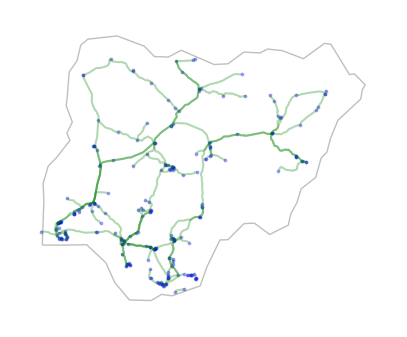

In [5]:
 ax = geoplot.polyplot(nigeriaplot, edgecolor="grey", alpha=0.5, figsize=(5, 5)) # Expand figsize for larger image

if option == "line2network":
    lines.plot(figsize=(5, 5), markersize=10, color="green", alpha=0.3, ax=ax)
    substations.plot(figsize=(5, 5), markersize=3, color="blue", alpha=0.3, ax=ax)

else:
    generators.plot(figsize=(5, 5), markersize=10, color="orange", alpha=0.3, ax=ax)
    lines.plot(figsize=(5, 5), markersize=10, color="green", alpha=0.3, ax=ax)
    substations.plot(figsize=(5, 5), markersize=3, color="blue", alpha=0.3, ax=ax)

# Example of how to constrain to one country:
# lines.loc[lines['country'] == 'nigeria'].plot(figsize=(20, 20),markersize=25, color='red',alpha = 0.3, ax=ax)

# #plt.savefig('africa_transmission_and substations_110.png')

# Interactive plot

Interactive plots are quite larger in size, so they are saved in an output html file under documentation folder. They can be opened through any browser

In [6]:
# Choose the country you want to focus
country = "NG"

In [7]:
if option == "line2network":
    lines_ng = lines[lines["country"] == country]
    substations_ng = substations[substations["country"] == country]

else:
    lines_ng = lines[lines["Country"] == country] # "country" for option = clean
    substations_ng = substations[substations["Country"] == country] # "country" for option = clean
    generators_ng = generators[generators["Country"] == country]

# Map

In [8]:
# Somehow works with "if" when using display()

if option == "line2network":
    line2network_BL = substations_ng.hvplot( # Buses and Lines
        geo=True,
        size=10,
        frame_height=750,
        alpha=0.4,
        tiles="CartoLight",
        hover_cols=["bus_id"],
        color="orange",
    ) * lines_ng.hvplot(geo=True, alpha=0.4, hover_cols=["line_id"]).opts(
        active_tools=["pan", "wheel_zoom"]
    )
    hvplot.save(line2network_BL, "documentation/line2network_BL.html")

else:
    raw_clean = substations_ng.hvplot(
        geo=True,
        size=10,
        frame_height=750,
        alpha=0.4,
        tiles="CartoLight",
        hover_cols=["bus_id"],
        color="orange",
    ) * lines_ng.hvplot(
        geo=True, alpha=0.4, hover_cols=["line_id"]
    ) * generators_ng.hvplot(
        geo=True, alpha=0.4, color="green"
    ).opts(
        active_tools=["pan", "wheel_zoom"]
    )
    hvplot.save(raw_clean, "documentation/raw_clean.html")




In [9]:
# With transformers
line2network_BLT = substations_ng.hvplot( # Buses, Lines and Transformers
    geo=True,
    size=10,
    frame_height=750,
    alpha=0.4,
    tiles="CartoLight",
    hover_cols=["bus_id"],
    color="orange",
) * lines_ng.hvplot(geo=True, alpha=0.4, hover_cols=["line_id"]).opts(
    active_tools=["pan", "wheel_zoom"]
) * transformers.hvplot(
    geo=True, linesize=30, color="red", alpha=0.4, hover_cols=["line_id"]
).opts(
    active_tools=["pan", "wheel_zoom"]
)
hvplot.save(line2network_BLT, "documentation/line2network_BLT.html")
